# Word2Vec

In the previous section, we have explored a model that predicts a word based on the word preceding it (the bi-gram model).
It used a logistic multi-class logistic regression to predict the next word.

For a single bi-gram, the input to the model is a one-hot encoded vector representing the preceding word (indicator vector with a 1 at the index of the word and 0s elsewhere).
The output of the model is a probability distribution over the vocabulary, meaning a vector of probabilities for each word in the vocabulary.

The training of the model adjusts the weights of the logistic regression to maximize the log-likelihood (minimize the negative log-likelihood or cross-entropy loss) of the observed word pairs in the training data.
The training uses the actual distribution of the next word which is again a one-hot encoded vector that assigns all the probability mass to the actual next word.

Here we want to address one limitation of this approach and that is the number of parameters.

$$
z = W x + b = \begin{bmatrix}
w_{11} & w_{12} & \dots & w_{1V} \\
w_{21} & w_{22} & \dots & w_{2V} \\
\vdots & \vdots & \ddots & \vdots \\
w_{D1} & w_{D2} & \dots & w_{VV}
\end{bmatrix}
\begin{bmatrix}
x_{1} \\
x_{2} \\
\vdots \\
x_{V}
\end{bmatrix} + 
\begin{bmatrix}
b_{1} \\
b_{2} \\
\vdots \\
b_{V}
\end{bmatrix}
= \begin{bmatrix}
z_{1} \\
z_{2} \\
\vdots \\
z_{V}
\end{bmatrix}
$$

$$
\hat{y} = \text{softmax}(z)
$$


![Skip-gram Model](./figures/skip-gram-architecture.webp)


Where $V$ is the vocabulary size. One way to reduce the number of parameters is to introduce a hidden layer with a smaller dimension $D$ (where $D << V$).

$$
h = W_{h} x + b_{h} = \begin{bmatrix}
w_{11} & w_{12} & \dots & w_{1V} \\
w_{21} & w_{22} & \dots & w_{2V} \\
\vdots & \vdots & \ddots & \vdots \\
w_{D1} & w_{D2} & \dots & w_{DV}
\end{bmatrix}
\begin{bmatrix}
x_{1} \\
x_{2} \\
\vdots \\
x_{V}
\end{bmatrix} + 
\begin{bmatrix}
b_{1} \\
b_{2} \\
\vdots \\
b_{D}
\end{bmatrix}
= \begin{bmatrix}
h_{1} \\
h_{2} \\
\vdots \\
h_{D}
\end{bmatrix}
$$



We will set the activation function of this hidden layer to be the identity function (we will explain this choice later).

$$
z = W_{o} h + b_{o} = \begin{bmatrix}
w^{o}_{11} & w^{o}_{12} & \dots & w^{o}_{1D} \\
w^{o}_{21} & w^{o}_{22} & \dots & w^{o}_{2D} \\
\vdots & \vdots & \ddots & \vdots \\
w^{o}_{V1} & w^{o}_{V2} & \dots & w^{o}_{VD}
\end{bmatrix}
\begin{bmatrix}
h_{1} \\
h_{2} \\
\vdots \\
h_{D}
\end{bmatrix} + 
\begin{bmatrix}
b^{o}_1 \\
b^{o}_2 \\
\vdots \\
b^{o}_V
\end{bmatrix}
= \begin{bmatrix}
z_{1} \\
z_{2} \\
\vdots \\
z_{V}
\end{bmatrix}
$$

The prediction is again the result of applying the softmax function to the output layer:

$$
\hat{y} = \text{softmax}(z)
$$

Let's now count the number of parameters in this model:

- We have the weights mapping the input layer to the hidden layer: $W_{h}$ with $D \times V$ parameters.
- We have the biases of the hidden layer: $b_{h}$ with $D$ parameters.
- We have the weights mapping the hidden layer to the output layer: $W_{o}$ with $V \times D$ parameters.
- We have the biases of the output layer: $b_{o}$ with $V$ parameters.

So in total, we have: $D \times V + D + V \times D + V = 2 \times D \times V + D + V$ parameters. With a vocabulary size of *10,000* and a hidden layer size of *100*, we have approximately 2,001,000 parameters.

Compare it to the number of parameters in the logistic regression version which is $V \times V + V = 100,010,000$ parameters.


In [54]:
V = 10_000
D = 100

print(f"Number of parameters with the hidden layer: {2 * V * D + D + V:,}")
print(f"Number of parameters of the logistic regression model: {V * V + V:,}")

Number of parameters with the hidden layer: 2,010,100
Number of parameters of the logistic regression model: 100,010,000


Let's get rid of the biases for simplicity. Without them, the equations for the two layers become:

$$
h = W_{h} x = \begin{bmatrix}
w_{11} & w_{12} & \dots & w_{1V} \\
w_{21} & w_{22} & \dots & w_{2V} \\
\vdots & \vdots & \ddots & \vdots \\
w_{D1} & w_{D2} & \dots & w_{DV}
\end{bmatrix}
\begin{bmatrix}
x_{1} \\
x_{2} \\
\vdots \\ 
x_{V}
\end{bmatrix} = \begin{bmatrix}
h_{1} \\
h_{2} \\
\vdots \\
h_{D}
\end{bmatrix}
$$
$$
z = W_{o} h = \begin{bmatrix}
w^{o}_{11} & w^{o}_{12} & \dots & w^{o}_{1D} \\
w^{o}_{21} & w^{o}_{22} & \dots & w^{o}_{2D} \\
\vdots & \vdots & \ddots & \vdots \\
w^{o}_{V1} & w^{o}_{V2} & \dots & w^{o}_{VD}
\end{bmatrix}
\begin{bmatrix}
h_{1} \\
h_{2} \\
\vdots \\
h_{D}
\end{bmatrix} = \begin{bmatrix}
z_{1} \\
z_{2} \\
\vdots \\
z_{V}
\end{bmatrix}
$$



Remember that the input $x$ is a one-hot encoded vector, so the matrix-vector multiplication in the first layer simply selects the column of $W_{h}$ corresponding to the index of the word represented by $x$.

The output layer for word $i$ can be rewritten as:

$$
\begin{bmatrix}
z_{1} \\
z_{2} \\
\vdots \\
z_{V}
\end{bmatrix} = 
\begin{bmatrix}
w^{o}_{11} & w^{o}_{12} & \dots & w^{o}_{1D} \\
w^{o}_{21} & w^{o}_{22} & \dots & w^{o}_{2D} \\
\vdots & \vdots & \ddots & \vdots \\
w^{o}_{V1} & w^{o}_{V2} & \dots & w^{o}_{VD}
\end{bmatrix}
\begin{bmatrix}
w_{1i} \\
w_{2i} \\
\vdots \\
w_{Di}
\end{bmatrix} = 
\begin{bmatrix}
w^{o}_{1} \cdot w_{i} \\
w^{o}_{2} \cdot w_{i} \\
\vdots \\
w^{o}_{V} \cdot w_{i}
\end{bmatrix} = 
\begin{bmatrix}
w^{o}_{11} w_{1i} + w^{o}_{12} w_{2i} + \dots + w^{o}_{1D} w_{Di} \\
w^{o}_{21} w_{1i} + w^{o}_{22} w_{2i} + \dots + w^{o}_{2D} w_{Di} \\
\vdots \\
w^{o}_{V1} w_{1i} + w^{o}_{V2} w_{2i} + \dots + w^{o}_{VD} w_{Di}
\end{bmatrix}
$$

The prediction is still obtained by applying the softmax function to the output layer:

$$
\hat{y} = \text{softmax}(z)
$$

Let's focus on what we are going to optimize during training. The objective is to minimize the cross-entropy loss between the predicted distribution $\hat{y}$ and the actual distribution $y$ (one-hot encoded vector of the actual next word)
but this time we have two sets of parameters: a vector representing each word in the hidden layer and a vector representing each word in the output layer. Let's write the softmax function for a specific word $i$:

$$
\hat{y}_{j} = \frac{\exp(w^{o}_{j} \cdot w_{i})}{\sum_{k=1}^{V} \exp(w^{o}_{k} \cdot w_{i})}
$$

and the log-likelihood for the actual next word $y$:

$$
l = \sum_{j=1}^{V} y_{j} \log(\hat{y}_{j})
$$


## Example

Let's see a very simple example with just four words in the vocabulary: **"Alice", "was", "getting", "tired"**, a hidden layer of size 2, and the bi-grams **("Alice", "was")**, **("was", "getting")**, **("getting", "tired")**. To not get confused with the indices, we will assign each word an index as follows:

| Word     | Index (Math) | Index (Numpy) |
|----------|-------|-------------|
| Alice    | 1     | 0           |
| getting  | 2     | 1          |
| tired    | 3     | 2          |
| was      | 4     | 3           |

The first weight matrix $W_{h}$ (input to hidden) will have the following shape: (2, 4) and the second weight matrix $W_{o}$ (hidden to output) will have the shape: (4, 2).

$$
W_{h} = \begin{bmatrix}
w_{11} & w_{12} & w_{13} & w_{14} \\
w_{21} & w_{22} & w_{23} & w_{24}
\end{bmatrix}
\quad
W_{o} = \begin{bmatrix}
w^{o}_{11} & w^{o}_{12} \\
w^{o}_{21} & w^{o}_{22} \\
w^{o}_{31} & w^{o}_{32} \\
w^{o}_{41} & w^{o}_{42}
\end{bmatrix}
$$


In [55]:
import numpy as np

V = 4
D = 2

np.random.seed(32)

Wh = np.random.randn(D, V)
Wo = np.random.randn(V, D)

print("Wh:")
print(Wh)

print("\nWo:")
print(Wo)
print("\nWh shape:", Wh.shape)
print("Wo shape:", Wo.shape)

Wh:
[[-0.34889445  0.98370343  0.58092283  0.07028444]
 [ 0.77753268  0.58195875  1.47179053  1.66318101]]

Wo:
[[-0.26117712 -0.68867681]
 [-0.69492326  1.94042346]
 [ 1.80541519  0.45631385]
 [-0.57481204  0.1141805 ]]

Wh shape: (2, 4)
Wo shape: (4, 2)


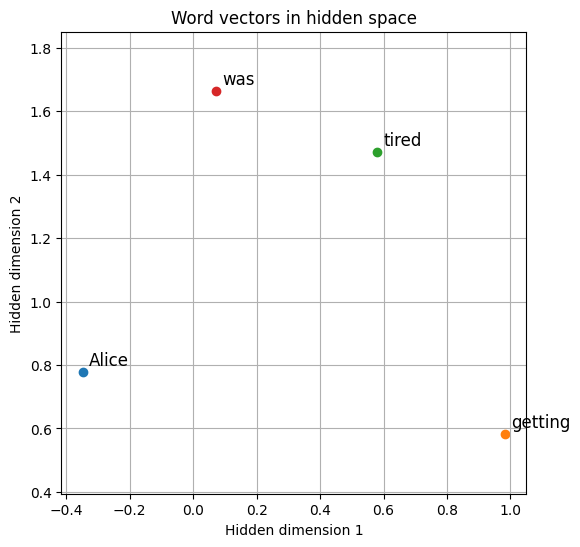

In [56]:
import matplotlib.pyplot as plt

words = ["Alice", "getting", "tired", "was"]

plt.figure(figsize=(6, 6))
for i, word in enumerate(words):
    plt.scatter(Wh[0, i], Wh[1, i], marker='o')
    plt.text(Wh[0, i] + 0.02, Wh[1, i] + 0.02, word, fontsize=12)

plt.xlabel("Hidden dimension 1")
plt.ylabel("Hidden dimension 2")
plt.title("Word vectors in hidden space")
plt.grid(True)
plt.axis('equal')
plt.show()

In [57]:
# For the first word (Alice, at this case index 0 in the vocabulary in numpy)

x_alice = np.zeros(V)
x_alice[0] = 1

print("\nx_alice:")
print(x_alice)


x_alice:
[1. 0. 0. 0.]


In [58]:
h = Wh @ x_alice

print("\nh:")
print(h)

z = Wo.dot(h)
print("\nz:")
print(z)

y_hat = np.exp(z) / np.sum(np.exp(z))
print("\ny_hat:")
print(y_hat)

print("\nThe actual word following 'Alice' is 'was', which is index 4 in the vocabulary (3 in numpy).")

y_was = np.zeros(V)
y_was[3] = 1

print("\ny_was:")
print(y_was)



h:
[-0.34889445  0.77753268]

z:
[-0.44434548  1.75119752 -0.27510041  0.2893278 ]

y_hat:
[0.07546027 0.6780014  0.08937593 0.1571624 ]

The actual word following 'Alice' is 'was', which is index 4 in the vocabulary (3 in numpy).

y_was:
[0. 0. 0. 1.]


In [59]:
# Now calculate the loss

loss = -np.log(y_hat).dot(y_was)
print("\nLoss:")
print(loss)


Loss:
1.8504756415153232


In [60]:
# This is the same as np.log(y_hat[3])

-np.log(y_hat[3])

np.float64(1.8504756415153232)

In [61]:
# Think about when the loss will be as small as possible.
# If the model outputs a prediction of 1.0 for the correct word,

# the loss will be -log(1.0) = 0, which is the smallest possible value for the loss.

np.log(1.0)

np.float64(0.0)

## Gradient Descent Updates

We repeat the model equations here for convenience:

$$
\begin{align*}
h & = W_{h} x \\
z & = W_{o} h \\
\hat{y} & = \text{softmax}(z) \\
L & = -\sum_{i=1}^{V} y_{i} \log(\hat{y}_{i})
\end{align*}
$$

Here we present the gradient descent update equations without derivation. For a detailed derivation, please refer to the last section of this chapter.


First define the prediction error vector:

$$
\delta = \underbrace{\hat{y} - y}_{V \times 1}
$$

**Output Layer Weights (`W_o`, shape V×D):**

$$
\underbrace{\frac{\partial L}{\partial W_{o}}}_{V \times D} = \underbrace{(\hat{y} - y)}_{V \times 1} \, \underbrace{h^{\top}}_{1 \times D}
$$

Gradient descent update:

$$
W_{o} \leftarrow W_{o} - \eta \, \frac{\partial L}{\partial W_{o}} = W_{o} - \eta \, (\hat{y} - y) \, h^{\top}.
$$



**Hidden Layer Weights (`W_h`, shape D×V):**

$$
\underbrace{\frac{\partial L}{\partial W_{h}}}_{D \times V} = \left(\underbrace{W_{o}^{\top}}_{D \times V} \underbrace{(\hat{y} - y)}_{V \times 1}\right) \, \underbrace{x^{\top}}_{1 \times V}.
$$

Gradient descent update:

$$
W_{h} \leftarrow W_{h} - \eta \, \frac{\partial L}{\partial W_{h}} = W_{h} - \eta \, \left(W_{o}^{\top} (\hat{y} - y)\right) \, x^{\top}.
$$

Because in our case the input $x$ is one-hot (with active index $i$), only column $i$ of `W_h` gets updated:

$$
W_{h}[:, i] \leftarrow W_{h}[:, i] - \eta \, W_{o}^{\top} (\hat{y} - y).
$$

All other columns remain unchanged for that training example.

{{< video videos/BiGramTraining.mp4 >}}

## The Skip-Gram Model

In the bi-gram model, we have seen how we can embed words in a dense (fixed-size) vector space by predicting the next word based on the current word and training a neural network with a hidden layer to do so.

We now extend this idea to try to produce embeddings that capture more context by predicting surrounding words based on the current word. In effect, instead of generating a single output word, we will generate multiple output words (the context) based on a single input word (the center word). This is known as the skip-gram model.

Let's take a break from Alice in Wonderland and consider the following sentence (from The Picture of Dorian Gray by Oscar Wilde):

**They are simply cheques that men draw on a bank where they have no account.**

1. _**They** are simply_ cheques that men draw on a bank where they have no account.
    Center: They
    Context: are, simply
2. _They **are** simply cheques_ that men draw on a bank where they have no account.
    Center: are
    Context: They, simply, cheques
4. _They are **simply** cheques that__ men draw on a bank where they have no account.
    Center: simply
    Context: They, are, cheques, that
5. They _are simply **cheques** that men_ draw on a bank where they have no account.
    Center: cheques
    Context: are, simply, that, men
6. They are __simply cheques **that** men draw_ on a bank where they have no account.
7. They are simply _cheques that **men** draw on__ a bank where they have no account.
8. They are simply cheques _that men **draw** on a_ bank where they have no account.

In [62]:
from nltk.tokenize import word_tokenize

sentence = "They are simply cheques that men draw on a bank where they have no account".lower()
tokens = word_tokenize(sentence)

window_size = 2
skipgram_samples = []

for idx, center_word in enumerate(tokens):
    print(f"\nCenter word: '{center_word}' (index {idx})")
    
    for offset in range(-window_size, window_size + 1):
        context_idx = idx + offset
        
        if offset == 0 or context_idx < 0 or context_idx >= len(tokens):
            continue
        context_word = tokens[context_idx]

        print(f"  Context word: '{context_word}' (index {context_idx})")
        skipgram_samples.append((center_word, context_word))

print("Tokens:", tokens)
print("Skip-gram samples (center, context):")
for sample in skipgram_samples:
    print(sample)


Center word: 'they' (index 0)
  Context word: 'are' (index 1)
  Context word: 'simply' (index 2)

Center word: 'are' (index 1)
  Context word: 'they' (index 0)
  Context word: 'simply' (index 2)
  Context word: 'cheques' (index 3)

Center word: 'simply' (index 2)
  Context word: 'they' (index 0)
  Context word: 'are' (index 1)
  Context word: 'cheques' (index 3)
  Context word: 'that' (index 4)

Center word: 'cheques' (index 3)
  Context word: 'are' (index 1)
  Context word: 'simply' (index 2)
  Context word: 'that' (index 4)
  Context word: 'men' (index 5)

Center word: 'that' (index 4)
  Context word: 'simply' (index 2)
  Context word: 'cheques' (index 3)
  Context word: 'men' (index 5)
  Context word: 'draw' (index 6)

Center word: 'men' (index 5)
  Context word: 'cheques' (index 3)
  Context word: 'that' (index 4)
  Context word: 'draw' (index 6)
  Context word: 'on' (index 7)

Center word: 'draw' (index 6)
  Context word: 'that' (index 4)
  Context word: 'men' (index 5)
  Context

## Negative Sampling

The skip-gram model until now only differs from the bi-gram model in the way we generate the training samples. However, it turns out that outputting a prediction for the whole vocabulary at each step is computationally expensive, especially for large vocabularies. Computing the softmax over a large vector is computationally intensive and requires updating a large number of parameters during training. To address this, the authors of Word2Vec introduced a technique called negative sampling.

Negative sampling means that instead of predicting the entire vocabulary, the model should only predict a small number of "negative" samples (words that are not in the context) along with the actual context words. This significantly reduces the computational load and speeds up training.

Let's see how this looks like in our example sentence:

| Center word  | Context word | Sample type | $y_i$ |
|---------|---------|-------------|-------|
| cheques | are     | positive    | 1     |
| cheques | simply  | positive    | 1     |
| cheques | that    | positive    | 1     |
| cheques | men     | positive    | 1     |
| cheques | happy    | negative    | 0     |
| cheques | people    | negative    | 0     |
| cheques | break      | negative    | 0     |
| cheques | plan    | negative    | 0     |



The model objective of the model now is to minimize the loss for predicting the positive samples as 1 and the negative samples as 0 (using binary cross-entropy loss) instead of predicting the entire vocabulary distribution.

The predicted probability for a context word $w_c$ given a center word $w_i$ is computed using the sigmoid function:

$$
\hat{y} = \sigma (w^{o}_{c} \cdot w_{i}) = \frac{1}{1 + \exp(-w^{o}_{c} \cdot w_{i})}
$$

and now $\hat{y}$ is a single number between 0 and 1 representing the probability that $w_c$ is a context word of $w_i$, not an entire vector of probabilities over the vocabulary. 

To avoid confusion, let's write the binary cross-entropy loss for each sample $(w_i, w_c)$:

1. Cheques - are (positive sample): 
   $$
   L_{\text{cheques-are}} = - y_{\text{cheques-are}}\log(\hat{y}_{\text{cheques-are}}) + (1 - y_{\text{cheques-are}})\log(1 - \hat{y}_{\text{cheques-are}}) = - \log(\hat{y}_{\text{cheques-are}})
    $$

   Because the outcome indicator $y_{\text{cheques-are}}$ is 1 for positive samples this reduces to

    $$
    L_{\text{cheques-are}} = - \log(\hat{y}_{\text{cheques-are}})
    $$

2. Cheques - happy (negative sample):
    $$
    L_{\text{cheques-happy}} = - y_{\text{cheques-happy}}\log(\hat{y}_{\text{cheques-happy}}) + (1 - y_{\text{cheques-happy}})\log(1 - \hat{y}_{\text{cheques-happy}})
    $$

    Here the outcome indicator $y_{\text{cheques-happy}}$ is 0 for negative samples, so this reduces to

    $$
    L_{\text{cheques-happy}} = - \log(1 - \hat{y}_{\text{cheques-happy}})
    $$


So for any center word $w_i$ and context/negative sample word $w_c$, the loss can be summarized as:

The training for the center word "cheques" with the context words as in the table above would involve minimizing the following loss:

$$
L = - \left( \sum_{(w_i, w_c) \in D^{+}} \log(\hat{y}) + \sum_{(w_i, w_c) \in D^{-}} \log(1 - \hat{y}) \right)
$$

Where $D^{+}$ is the set of positive samples and $D^{-}$ is the set of negative samples.


{{< video videos/SkipGramTraining.mp4 >}}

## Choosing Negative Samples

A natural question is how to choose the negative examples. The authors of the skip-gram model suggest using the uni-gram distribution raised to the 3/4 power in order sample frequent words less often.

$$
p("the") = \frac{\text{frequency of "the"}}{\text{total number of words}}
$$

The uni-gram distribution raised to the 3/4 power is:

$$
p^1("the") = \frac{p(\text{"the"})^{3/4}}{
\sum_{w \in V} p(w)^{3/4}}
$$

where the sum in the denominator is the sum of the frequency of each word in the corpus raised to the 3/4 power so that $p^1$ is a probability distribution over the vocabulary. The 3/4 power is used to reduce the probability of sampling very frequent words and is a hyperparameter of the model.

## Subsampling Frequent Words

A pattern occurring in most human language texts is that some words are much more frequent than others. There is an empirical finding known as Zipf's law that states that the frequency of a word is inversely proportional to its rank in the frequency table. For example, the most frequent word will occur twice as often as the second most frequent word, three times as often as the third most frequent word, and so on.

$$
\text{word frequency} \propto \frac{1}{\text{word rank}}
$$

In [63]:
import numpy as np
import nltk

nltk.download("gutenberg")
from nltk.corpus import gutenberg
import spacy

nlp = spacy.load("en_core_web_sm")
gutenberg.fileids()
alice = gutenberg.raw(fileids="carroll-alice.txt")

[nltk_data] Downloading package gutenberg to /home/amarov/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [64]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
words = word_tokenize(alice)
words = [word.lower() for word in words if word.isalpha()]

words_freq_dist = FreqDist(words)
words_freq_dist.most_common(20)

[('the', 1616),
 ('and', 810),
 ('to', 720),
 ('a', 631),
 ('she', 545),
 ('i', 543),
 ('it', 540),
 ('of', 499),
 ('said', 462),
 ('alice', 397),
 ('was', 367),
 ('in', 359),
 ('you', 359),
 ('that', 284),
 ('as', 256),
 ('her', 248),
 ('at', 209),
 ('on', 191),
 ('had', 185),
 ('with', 179)]

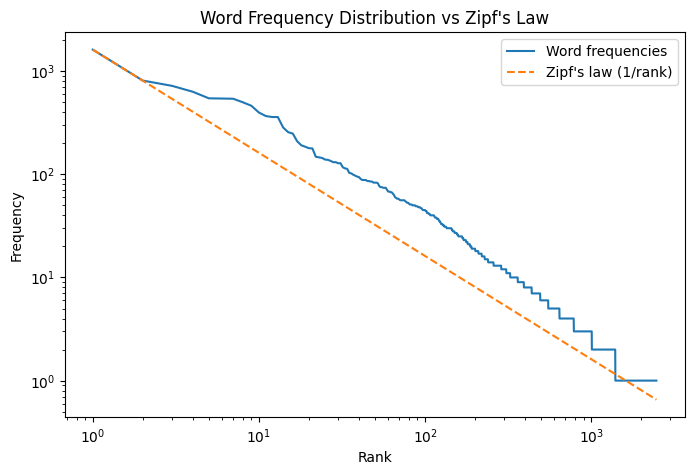

In [65]:
import numpy as np

import matplotlib.pyplot as plt

# Get frequencies sorted by rank
freqs = np.array(sorted(words_freq_dist.values(), reverse=True))
ranks = np.arange(1, len(freqs) + 1)

plt.figure(figsize=(8, 5))
plt.plot(ranks, freqs, label="Word frequencies")
plt.plot(ranks, freqs[0] / ranks, label="Zipf's law (1/rank)", linestyle='--')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title("Word Frequency Distribution vs Zipf's Law")
plt.legend()
plt.show()

Because some words are used very often (e.g., the), they provide little information about the context. Furthermore, the training will spend a lot of time learning the word vectors for these words.

A solution is to drop some of the frequent words from the training data. The authors of the skip-gram model suggest dropping words with a probability of:

$$
P_{drop}(w) = 1 - \sqrt{\frac{\text{threshold}}{p^1(w)}}
$$

with a threshold of $t = 10^{-5}$ and $p^1(w)$ is modified uni-gram distribution.

Consider our running example:

```
Alice was beginning to get very **tired** of sitting by her sister on the bank.
```

and suppose that we drop the words "get" and "of" of the words in the sentence. The sentence will become:

```
Alice was beginning to very **tired** sitting by her sister on the bank.
```

What is the effect of this technique on the context window size?

## Gradient Descent Updates with Negative Sampling

With the model

$$
\begin{align*}
\hat{y} & = \sigma (w^{o}_{c} \cdot w_{i}) \\
L & = - y \log(\hat{y}) - (1 - y) \log(1 - \hat{y})
\end{align*}
$$

Note that as only the embeddings of the center word $w_i$ and the context/negative sample word $w_c$ are involved in the computation of $\hat{y}$, only these embeddings will be updated during training because the loss $L$ does not depend on any other embeddings.

For the full derivation see the technical appendix. Here we present only the final gradient descent update equations.

**Output Layer Embedding (`w^o_c`, shape D×1):**

$$
\underbrace{\frac{\partial L}{\partial w^{o}_{c}}}_{D \times 1} = \frac{\partial L}{\partial a} \frac{\partial a}{\partial w^{o}_{c}} = \underbrace{(\hat{y} - y)}_{\text{scalar}} \, \underbrace{w_{i}}_{D \times 1}
$$

Gradient descent update:

$$
w^{o}_{c} \leftarrow w^{o}_{c} - \eta \, \frac{\partial L}{\partial w^{o}_{c}} = w^{o}_{c} - \eta \, (\hat{y} - y) \, w_{i}.
$$


**Hidden Layer Embedding (`w_i`, shape D×1):**

$$
\underbrace{\frac{\partial L}{\partial w_{i}}}_{D \times 1} = \frac{\partial L}{\partial a} \frac{\partial a}{\partial w_{i}} = \underbrace{(\hat{y} - y)}_{\text{scalar}} \, \underbrace{w^{o}_{c}}_{D \times 1}
$$


## Implementation in Numpy

Next we want to implement the skip-gram model with negative sampling in Numpy. We need several steps and for ease of understanding, we will break them up into separate code cells.

1. Prepare the data
   - We need to split the text into sentences, then into words, and build a vocabulary.
   - We need to know the size of the vocabulary $V$ and the embedding dimension $D$ in order to set up the weight matrices.
   - We need to know the index of each word in the vocabulary to be able to access its embedding vector.
   - We need to generate the training samples (center word, context word) pairs along with negative samples for each center word.
   - We need to compute the unigram distribution raised to the 3/4 power for negative sampling.

2. Initialize the embeddings
   - We need to initialize two embedding matrices: one for the input (center words) and one for the output (context/negative sample words).
   - The input embedding matrix will have shape (D, V) and the output embedding matrix will have shape (V, D).

3. The actual training loop
   - For each training sample (center word, context word, positive/negative label):
     - Compute the predicted probability $\hat{y}$ using the current embeddings.
     - Compute the loss using binary cross-entropy.
     - Compute the gradients with respect to the embeddings.
     - Update the embeddings using gradient descent.
  
Below is a simplified implementation of the skip-gram model with negative sampling in Numpy.

In [66]:
# Main training function
def train_skipgram(tokens, word2idx, idx2word, word_freq, embedding_dim=10, 
                   learning_rate=0.01, window_size=2, num_negative_samples=5, 
                   epochs=1, subsampling_threshold=1e-3):
    """
    Train Skip-Gram model with negative sampling.
    
    Args:
        tokens: List of tokens
        word2idx: Word to index mapping
        idx2word: Index to word mapping
        word_freq: Word frequencies dictionary
        embedding_dim: Dimension of embeddings
        learning_rate: Learning rate
        window_size: Context window size
        num_negative_samples: Number of negative samples
        epochs: Number of training epochs
        subsampling_threshold: Threshold for subsampling
        
    Returns:
        W_in: Trained input embeddings
    """
    vocab_size = len(word2idx)
    
    # Initialize embeddings
    W_in, W_out = initialize_embeddings(vocab_size, embedding_dim)
    
    # Compute unigram distribution for negative sampling
    unigram_dist = compute_unigram_distribution(word_freq, vocab_size)
    
    # Compute subsampling probabilities
    keep_probs = compute_subsampling_probs(tokens, word2idx, word_freq, subsampling_threshold)
    
    # Training loop
    for epoch in range(epochs):
        total_pairs = 0
        
        for idx, word in enumerate(tokens):
            # Apply subsampling
            if np.random.random() > keep_probs.get(word, 1.0):
                continue
            
            if word not in word2idx:
                continue
            
            center_idx = word2idx[word]
            
            # Generate context words within window
            for offset in range(-window_size, window_size + 1):
                if offset == 0:
                    continue
                
                context_idx_pos = idx + offset
                if context_idx_pos < 0 or context_idx_pos >= len(tokens):
                    continue
                
                context_word = tokens[context_idx_pos]
                if context_word not in word2idx:
                    continue
                
                context_idx = word2idx[context_word]
                
                # Train on this pair
                train_pair(center_idx, context_idx, W_in, W_out, learning_rate,
                          num_negative_samples, unigram_dist, vocab_size)
                total_pairs += 1
        
        print(f"Epoch {epoch + 1}/{epochs}, Processed {total_pairs} training pairs")
    
    return W_in, W_out

In [67]:
# Example: Train Skip-Gram model
from nltk.tokenize import word_tokenize
import nltk

# Download required NLTK data
nltk.download('punkt', quiet=True)

# Sample text corpus
corpus = """
The quick brown fox jumps over the lazy dog.
The dog was lazy and slept all day.
The fox was quick and clever.
A brown dog ran through the woods.
"""

# Tokenize and prepare data
tokens = word_tokenize(corpus.lower())
print(f"Total tokens: {len(tokens)}")
print(f"Sample tokens: {tokens[:20]}")

# Build vocabulary
word2idx, idx2word, word_freq = build_vocabulary(tokens, min_count=1)
print(f"\nVocabulary size: {len(word2idx)}")
print(f"Most common 10 words: {sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:10]}")

# Train the model
print("\n" + "="*50)
print("Training Skip-Gram Model")
print("="*50)

W_in, W_out = train_skipgram(
    tokens=tokens,
    word2idx=word2idx,
    idx2word=idx2word,
    word_freq=word_freq,
    embedding_dim=5,
    learning_rate=0.01,
    window_size=2,
    num_negative_samples=5,
    epochs=10,
    subsampling_threshold=1e-3
)

print(f"\nTraining complete!")
print(f"Embedding dimensions: {W_in.shape}")  # (vocab_size, embedding_dim)

Total tokens: 34
Sample tokens: ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '.', 'the', 'dog', 'was', 'lazy', 'and', 'slept', 'all', 'day', '.', 'the']


NameError: name 'build_vocabulary' is not defined

### Preparing the Data

In [ ]:
import nltk
nltk.download("gutenberg")

from nltk.corpus import gutenberg

# Read the full text of "Alice in Wonderland" from the Gutenberg corpus
alice_text = gutenberg.raw(fileids="carroll-alice.txt")
print(alice_text[:300])  # Print the first 1000 characters as a preview

[Alice's Adventures in Wonderland by Lewis Carroll 1865]

CHAPTER I. Down the Rabbit-Hole

Alice was beginning to get very tired of sitting by her sister on the
bank, and of having nothing to do: once or twice she had peeped into the
book her sister was reading, but it had no pictures or conversatio


[nltk_data] Downloading package gutenberg to /home/amarov/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [ ]:
# Get a list of sentences and their tokens

from nltk.tokenize import sent_tokenize, word_tokenize

sentences = sent_tokenize(alice_text)

# A list (sentences) of lists (tokens in a single sentence) of tokens
tokenized_sentences = [
    [token for token in word_tokenize(sentence.lower()) if token.isalpha()] for sentence in sentences
    ]

# Print the first few sentences as preview

for sent_tokens in tokenized_sentences[:2]:
    print("#" * 20)
    for token in sent_tokens:
        print(token)
    
all_tokens = [token for sentence in tokenized_sentences for token in sentence if token.isalpha()]

####################
alice
adventures
in
wonderland
by
lewis
carroll
chapter
i
####################
down
the
alice
was
beginning
to
get
very
tired
of
sitting
by
her
sister
on
the
bank
and
of
having
nothing
to
do
once
or
twice
she
had
peeped
into
the
book
her
sister
was
reading
but
it
had
no
pictures
or
conversations
in
it
what
is
the
use
of
a
book
thought
alice
pictures
or
conversation


In [ ]:
# Count unique extracted tokens, this is the vocabulary size

V = len(set(all_tokens))

print(f"Total tokens: {len(all_tokens)}")
print(f"Vocabulary size: {V}")

Total tokens: 25501
Vocabulary size: 2470


In [ ]:
# Create a mapping from word to index and vice versa

word2idx = {word: idx for idx, (word, _) in enumerate(word_freq_dist.items())}
idx2word = {idx: word for word, idx in word2idx.items()}

print("Index of alice:", word2idx.get("alice", "Not found"))
print("Index of wonderland:", word2idx.get("wonderland", "Not found"))

Index of alice: 0
Index of wonderland: 3


In [ ]:
# Check that the reverse mapping works

print("Word at index of alice:", idx2word.get(0, "Not found"))
print("Word at index of wonderland:", idx2word.get(3, "Not found"))

Word at index of alice: alice
Word at index of wonderland: wonderland


In [ ]:
# After that, compute the word frequencies

from nltk.probability import FreqDist

word_freq_dist = FreqDist(all_tokens)
word_freq_dist.most_common(20)

[('the', 1616),
 ('and', 810),
 ('to', 720),
 ('a', 631),
 ('she', 545),
 ('i', 543),
 ('it', 540),
 ('of', 499),
 ('said', 462),
 ('alice', 397),
 ('was', 367),
 ('in', 359),
 ('you', 359),
 ('that', 284),
 ('as', 256),
 ('her', 248),
 ('at', 209),
 ('on', 191),
 ('had', 185),
 ('with', 179)]

In [ ]:
# Put it in a DataFrame for better handling
import pandas as pd

word_freq_df = pd.DataFrame(word_freq_dist.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)
word_freq_df.head(20)

,word,frequency
10,the,1616
23,and,810
13,to,720
44,a,631
30,she,545
8,i,543
37,it,540
17,of,499
221,said,462
0,alice,397


In [ ]:
# Create the subsampling probabilities

word_freq_df["p"] = word_freq_df["frequency"] / word_freq_df["frequency"].sum()
word_freq_df["p1"] = word_freq_df["p"]**(3/4)
word_freq_df["p1"] = word_freq_df["p1"] / word_freq_df["p1"].sum()

word_freq_df["word_idx"] = word_freq_df["word"].map(word2idx)
word_freq_df = word_freq_df.set_index("word_idx").sort_index()

drop_threshold = 1e-4

word_freq_df["p_drop"] = 1 - np.sqrt(drop_threshold / word_freq_df["p1"])

word_drop_p = word_freq_df["p_drop"].to_dict()
word_freq_df

,word,frequency,p,p1,p_drop
word_idx,,,,,
0,alice,397,0.015568,0.008780,0.893279
1,adventures,7,0.000274,0.000425,0.514841
2,in,359,0.014078,0.008142,0.889176
3,wonderland,3,0.000118,0.000225,0.333385
4,by,58,0.002274,0.002075,0.780462
...,...,...,...,...,...
2465,gather,1,0.000039,0.000099,-0.006458
2466,sorrows,1,0.000039,0.000099,-0.006458
2467,joys,1,0.000039,0.000099,-0.006458


In [ ]:
word_drop_p[0]

0.8932791755433553

In [ ]:
# A helper function to select negative samples based on the unigram distribution

def get_negative_samples(n):
    neg_words = word_freq_df["word"].sample(
        n=n,
        replace=True,
        weights=word_freq_df["p1"]
    )

    return [word2idx[word] for word in neg_words]


get_negative_samples(5)

[466, 1129, 1877, 17, 1817]

In [68]:
# Create the training pairs from the full text. Each pair is (center_word_idx, context_word_idx, positive/negative label)

training_pairs = []

for sentence in tokenized_sentences:
    sentence_length = len(sentence)
    
    # Skip too short sentences
    if sentence_length < 2:
        continue

    # Apply subsampling
    
    training_tokens = []

    for word in sentence:
        random_value_between_0_1 = np.random.random()
        drop_prob = word_drop_p.get(word2idx.get(word, -1), 0.0)
        if random_value_between_0_1 > drop_prob:
            training_tokens.append(word)
    

    sentence = [word for word in training_tokens]
    sentence_length = len(training_tokens)
        
    for center_pos, center_word in enumerate(training_tokens):
        center_idx = word2idx[center_word]
        
        # Define context window
        window_start = max(0, center_pos - 2)
        window_end = min(sentence_length, center_pos + 3)
        
        for context_pos in range(window_start, window_end):
            if context_pos == center_pos:
                continue
            
            context_word = sentence[context_pos]
            if context_word not in word2idx:
                continue
            
            context_idx = word2idx[context_word]
            
            # Positive sample
            training_pairs.append((center_idx, context_idx, 1))
            
            # Negative samples (should fix)
            negative_samples = get_negative_samples(4)
            for neg_idx in negative_samples:
                training_pairs.append((center_idx, neg_idx, 0))

In [80]:
training_pairs[8]

(1, 115, 0)

In [ ]:
# Now we are ready to write the training loop

# First we initialize the embedding matrices

Wh = np.random.randn(D, V) * 0.01
Wo = np.random.randn(V, D) * 0.01

# Then we say how many times we want to go through the full text
epochs = 5

# Also set the learning rate
learning_rate = 0.01

for epoch in range(epochs):
    # Shuffle training pairs each epoch so that the words are not always in the same order
    np.random.shuffle(training_pairs)
        
    total_loss = 0
    for center_idx, context_idx, y in training_pairs:
        # Forward pass: compute predicted y_hat

        w_i = Wh[:, center_idx]  # Hidden layer
        z = Wo[context_idx, :].dot(w_i)  # Output layer

        y_hat = 1 / (1 + np.exp(-z))  # Sigmoid: predicted probability
        loss = - (y * np.log(y_hat + 1e-10) + (1 - y) * np.log(1 - y_hat + 1e-10))  # Loss 

        # Record the total loss for printing
        total_loss += loss       

        # Backward pass: update the weights

        e = y_hat - y  # Error term
        Wo[context_idx, :] -= learning_rate * e * w_i  # Update output weights
        Wh[:, center_idx] -= learning_rate * e * Wo[context_idx, :]  # Update input weights

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(training_pairs):.4f}")

## Technical Appendix

### Derivation of Gradient Descent Updates in the Bi-gram Model

To derive the gradients for the gradient descent update equations we use the chain rule of calculus.

For the model

$$
\begin{align*}
h & = W_{h} x \\
z & = W_{o} h \\
\hat{y} & = \text{softmax}(z) \\
L & = -\sum_{i=1}^{V} y_{i} \log(\hat{y}_{i})
\end{align*}
$$

we need to compute the partial derivatives of the loss $L$ with respect to the weights $W_{h}$ and $W_{o}$. Note that the loss function is a scalar (a real number) 
and that its gradient with respect to a matrix is also a matrix of the same shape as the original matrix. So the 
gradient of the loss with respect to $W_{o}$ is a matrix of shape (V, D) and the gradient of the loss with respect to $W_{h}$ is a matrix of shape (D, V).

$$
\frac{\partial L}{\partial W_{o}} = \begin{bmatrix}
\frac{\partial L}{\partial w^{o}_{11}} & \frac{\partial L}{\partial w^{o}_{12}} & \dots & \frac{\partial L}{\partial w^{o}_{1D}} \\
\frac{\partial L}{\partial w^{o}_{21}} & \frac{\partial L}{\partial w^{o}_{22}} & \dots & \frac{\partial L}{\partial w^{o}_{2D}} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial L}{\partial w^{o}_{V1}} & \frac{\partial L}{\partial w^{o}_{V2}} & \dots & \frac{\partial L}{\partial w^{o}_{VD}}
\end{bmatrix}
\quad
\frac{\partial L}{\partial W_{h}} = \begin{bmatrix}
\frac{\partial L}{\partial w_{11}} & \frac{\partial L}{\partial w_{12}} & \dots & \frac{\partial L}{\partial w_{1V}} \\
\frac{\partial L}{\partial w_{21}} & \frac{\partial L}{\partial w_{22}} & \dots & \frac{\partial L}{\partial w_{2V}} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial L}{\partial w_{D1}} & \frac{\partial L}{\partial w_{D2}} & \dots & \frac{\partial L}{\partial w_{DV}}
\end{bmatrix}
$$

When computing the gradients it helps to first derive the gradient of the loss with respect to the output layer $z$. It is a vector of shape (V, 1), so 
the gradient is also a vector of shape (V, 1). As all other derivatives involve this term, it is useful to derive it first.

$$
\frac{\partial L}{\partial z} = \begin{bmatrix}
\frac{\partial L}{\partial z_{1}} \\
\frac{\partial L}{\partial z_{2}} \\
\vdots \\
\frac{\partial L}{\partial z_{V}}
\end{bmatrix}
$$

Let's start by deriving the loss with respect to a single element of the output layer $z_{k}$.

$$
\frac{\partial L}{\partial z_{k}} = \sum_{i=1}^{V} \frac{\partial L}{\partial \hat{y}_{i}} \frac{\partial \hat{y}_{i}}{\partial z_{k}} \quad \text{(chain rule)}
$$

**Note on the summation:** We could write the loss as $L = \sum_{i=1}^{V} L_i$ where $L_i = -y_{i} \log(\hat{y}_{i})$ is the contribution from category $i$. However, the sum in the chain rule above appears for a different reason: due to the softmax function, $z_k$ influences the total loss $L$ through *all* the predicted probabilities $\hat{y}_1, \hat{y}_2, \ldots, \hat{y}_V$ (not just $\hat{y}_k$). The summation accounts for all these coupled pathways through which changing $z_k$ affects $L$.

The first derivative in the chain rule is:

$$
\frac{\partial L}{\partial \hat{y}_{i}} = - y_i \frac{\partial}{\partial \hat{y}_{i}} \log(\hat{y}_{i}) = - \frac{y_i}{\hat{y}_{i}}
$$

The second derivative is a little bit more confusing because of the softmax function.

$$
\frac{\partial \hat{y}_{i}}{\partial z_{k}} = \frac{\partial}{\partial z_{k}} \left( \frac{\exp(z_{i})}{\sum_{j=1}^{V} \exp(z_{j})} \right)
$$

We need to distinguish two cases: when $i = k$ and when $i \neq k$ because the derivative will be different in these two cases (because $z_{k}$ appears in both the numerator and denominator of the softmax function).

When $i = k$:

$$
\begin{align*}
\frac{\partial \hat{y}_{i}}{\partial z_{i}} & = \frac{\partial}{\partial z_{i}} \left( \frac{\exp(z_{i})}{\sum_{j=1}^{V} \exp(z_{j})} \right) \\
& = \frac{\exp(z_{i}) \sum_{j=1}^{V} \exp(z_{j}) - \exp(z_{i}) \exp(z_{i})}{\left( \sum_{j=1}^{V} \exp(z_{j}) \right)^{2}} \\
& = \frac{\exp(z_{i})}{\sum_{j=1}^{V} \exp(z_{j})} \left( 1 - \frac{\exp(z_{i})}{\sum_{j=1}^{V} \exp(z_{j})} \right) \\
& = \hat{y}_{i} (1 - \hat{y}_{i})
\end{align*}
$$

In the other case, when $i \neq k$:

$$
\begin{align*}
\frac{\partial \hat{y}_{i}}{\partial z_{k}} & = \frac{\partial}{\partial z_{k}} \left( \frac{\exp(z_{i})}{\sum_{j=1}^{V} \exp(z_{j})} \right) \\
& = - \frac{\exp(z_{i}) \exp(z_{k})}{\left( \sum_{j=1}^{V} \exp(z_{j}) \right)^{2}} \\
& = - \frac{\exp(z_{i})}{\sum_{j=1}^{V} \exp(z_{j})} \frac{\exp(z_{k})}{\sum_{j=1}^{V} \exp(z_{j})} \\
& = - \hat{y}_{i} \hat{y}_{k}
\end{align*}
$$

To summarize:

$$
\frac{\partial \hat{y}_{i}}{\partial z_{k}} = \begin{cases}
\hat{y}_{i} (1 - \hat{y}_{i}) & \text{if } i = k \\
- \hat{y}_{i} \hat{y}_{k} & \text{if } i \neq k
\end{cases}
$$

Now let's use this result to compute the derivative of the loss with respect to $z_{k}$. What we do is to split the sum into two parts: one for the case when $i = k$ and another for the case when $i \neq k$.

$$
\begin{align*}
\frac{\partial L}{\partial z_{k}} & = \sum_{i=1}^{V} \frac{\partial L}{\partial \hat{y}_{i}} \frac{\partial \hat{y}_{i}}{\partial z_{k}} \\
& = \frac{\partial L}{\partial \hat{y}_{k}} \frac{\partial \hat{y}_{k}}{\partial z_{k}} + \sum_{i \neq k} \frac{\partial L}{\partial \hat{y}_{i}} \frac{\partial \hat{y}_{i}}{\partial z_{k}} \\
\end{align*}
$$

Then we substitute with the definition of the loss function and the derivatives we just computed:

$$
\begin{align*}
\frac{\partial L}{\partial z_{k}} & = - \frac{y_{k}}{\cancel{\hat{y}_{k}}} \cancel{\hat{y}_{k}} (1 - \hat{y}_{k}) + \sum_{i \neq k} \left(- \frac{y_{i}}{\cancel{\hat{y}_{i}}}\right) (- \cancel{\hat{y}_{i}} \hat{y}_{k}) \\
& = - y_{k} (1 - \hat{y}_{k}) - \sum_{i \neq k} y_{i}\hat{y}_{k} \\
\end{align*}
$$


With this expression we can notice two things:

1. $\hat{y}_k$ does not depend on the index of summation $i$ so we can factor it out of the sum.
2. The sum goes over all indices except $k$, so we can rewrite it as the full sum minus the term for index $k$ without changing its value. We do this
   to simplify the expression because we know that the sum of all elements of $y$ is equal to 1 (because it is a probability distribution).

These are the key considerations, what follows after that is just algebraic manipulation:

$$
\begin{align*}
\frac{\partial L}{\partial z_{k}} & = - y_{k} (1 - \hat{y}_{k}) - \hat{y}_{k} \sum_{i \neq k} y_{i} \\
& = - y_{k} (1 - \hat{y}_{k}) - \hat{y}_{k} \left(\sum_{i=1}^{V} y_{i} - y_{k}\right) \\
& = - y_{k} (1 - \hat{y}_{k}) - \hat{y}_{k} (1 - y_{k}) \\
& = - y_{k} + y_{k} \hat{y}_{k} - \hat{y}_{k} + y_{k} \hat{y}_{k} \\
& = \hat{y}_{k} - y_{k}
\end{align*}
$$

which is simply the difference between predicted distribution and the actual probability (the error) for class (word) $k$.

So the gradient of the loss with respect to the output layer pre-activation $z$ is:

$$
\frac{\partial L}{\partial z} = \hat{y} - y = \begin{bmatrix}
\hat{y}_{1} - y_{1} \\
\hat{y}_{2} - y_{2} \\
\vdots \\
\hat{y}_{V} - y_{V}
\end{bmatrix}
$$

Now that we have the intermediate step in the chain rule, let's develop it further to actually compute the gradients with respect to the output layer weights $W_{o}$ and then the hidden layer weights $W_{h}$.

#### Output Layer Gradient

$$
\frac{\partial L}{\partial w^{o}_{jk}} = \sum_{i=1}^{V} \frac{\partial L}{\partial z_{i}} \frac{\partial z_{i}}{\partial w^{o}_{jk}}
$$


We have already derived the first term in the chain rule, so now let's focus on the second term and for simplicity, let's choose the weight $w^{o}_{11}$. Furthermore, we'll copy the equation for $z_{i}$ here for convenience. We'll only change the index of the input word from $i$ to $l$ to avoid confusion with the index of summation.

$$
\begin{bmatrix}
z_{1} \\
z_{2} \\
\vdots \\
z_{V}
\end{bmatrix} = 
\begin{bmatrix}
w^{o}_{11} w_{1l} + w^{o}_{12} w_{2l} + \dots + w^{o}_{1D} w_{Dl} \\
w^{o}_{21} w_{1l} + w^{o}_{22} w_{2l} + \dots + w^{o}_{2D} w_{Dl} \\
\vdots \\
w^{o}_{V1} w_{1l} + w^{o}_{V2} w_{2l} + \dots + w^{o}_{VD} w_{Dl}
\end{bmatrix}
$$


First row of $z$ ($i = 1$):

$$
\frac{\partial z_{1}}{\partial w^{o}_{11}} = \frac{\partial}{\partial w^{o}_{11}} \left( w^{o}_{11} w_{1l} + w^{o}_{12} w_{2l} + \dots + w^{o}_{1D} w_{Dl}\right) = w_{1l}
$$

Now we'll notice that the derivative of all other rows of $z$ with respect to $w^{o}_{11}$ will be zero because $w^{o}_{11}$ only appears in the first row of $z$. So we can summarize:

$$
\frac{\partial z_{i}}{\partial w^{o}_{11}} = \begin
{cases}
w_{1l} & \text{if } i = 1 \\
0 & \text{if } i \neq 1
\end{cases}
$$

Continue doing this for $$w^{o}_{12}, w^{o}_{1 3}, \dots, w^{o}_{1 D}$$ and write the final result of the chain rule:

$$
\begin{align*}
\frac{\partial L}{\partial w^{o}_{11}} & = (\hat{y}_1 - y_1) w_{1l} \\
\frac{\partial L}{\partial w^{o}_{12}} & = (\hat{y}_1 - y_1) w_{2l} \\
\vdots \\
\frac{\partial L}{\partial w^{o}_{1D}} & = (\hat{y}_1 - y_1) w_{Dl}
\end{align*}
$$

For $w^{o}_{21}, w^{o}_{22}, \dots, w^{o}_{2D}$:

$$
\begin{align*}
\frac{\partial L}{\partial w^{o}_{21}} & = (\hat{y}_2 - y_2) w_{1l} \\
\frac{\partial L}{\partial w^{o}_{22}} & = (\hat{y}_2 - y_2) w_{2l} \\
\vdots \\
\frac{\partial L}{\partial w^{o}_{2D}} & = (\hat{y}_2 - y_2) w_{Dl}
\end{align*}
$$

Finally, combine all these columns into a matrix form:

$$
\frac{\partial L}{\partial W_{o}} = \begin{bmatrix}
(\hat{y}_1 - y_1) w_{1l} & (\hat{y}_1 - y_1) w_{2l} & \dots & (\hat{y}_1 - y_1) w_{Dl} \\
(\hat{y}_2 - y_2) w_{1l} & (\hat{y}_2 - y_2) w_{2l} & \dots & (\hat{y}_2 - y_2) w_{Dl} \\
\vdots & \vdots & \ddots & \vdots \\
(\hat{y}_V - y_V) w_{1l} & (\hat{y}_V - y_V) w_{2l} & \dots & (\hat{y}_V - y_V) w_{Dl}
\end{bmatrix}
$$

What you have obtained in simply the outer product between the error vector $(\hat{y} - y)$ of shape (V, 1) and the hidden layer vector $h$ of shape (1, D). In this special case of the input being one-hot encoded, the hidden layer $h$ is simply the column of $W_{h}$ corresponding to the index of the input word $l$.

$$
\frac{\partial L}{\partial W_{o}} = (\hat{y} - y) \, h^{\top} = (\hat{y} - y) \, W_{h}[:, l]^{\top}
$$


#### Hidden Layer Gradient

For the hidden layer with weights we can proceed in a similar fashion. We start with the chain rule:

$$
\frac{\partial L}{\partial w_{11}} = \sum_{i=1}^{V} \frac{\partial L}{\partial z_{i}} \frac{\partial z_{i}}{\partial w_{11}}
$$

For i = 1:

$$
\frac{\partial z_{1}}{\partial w_{11}} = \frac{\partial}{\partial w_{11}} \left( w^{o}_{11} w_{11} + w^{o}_{12} w_{21} + \dots + w^{o}_{1D} w_{D1} \right) = w^{o}_{11}
$$

For i = 2:

$$
\frac{\partial z_{2}}{\partial w_{11}} = \frac{\partial}{\partial w_{11}} \left( w^{o}_{21} w_{11} + w^{o}_{22} w_{21} + \dots + w^{o}_{2D} w_{D1} \right) = w^{o}_{21}
$$

Continuing this for all i, we have:

$$
\frac{\partial z_{i}}{\partial w_{11}} = w^{o}_{i1}
$$

Putting it all together in the chain rule:

$$
\begin{align*}
\frac{\partial L}{\partial w_{11}} & = \sum_{i=1}^{V} \frac{\partial L}{\partial z_{i}} \frac{\partial z_{i}}{\partial w_{11}} \\
& = \sum_{i=1}^{V} (\hat{y}_i - y_i) w^{o}_{i1} \\
\end{align*}
$$

Now this is nothing but the dot product between the output weights column vector $W_{o}[:, 1]$ and the error vector $(\hat{y} - y)$:


When you continue doing this you will notice that only the derivatives with respect to the weights in the column corresponding to the input word index $l$ will be non-zero because only these appear in the dot products in the rows of $z$.

So for the entire vector of weights corresponding to the input word index $l$ we have:

$$
\begin{bmatrix}
\frac{\partial L}{\partial w_{1l}} \\
\frac{\partial L}{\partial w_{2l}} \\
\vdots \\
\frac{\partial L}{\partial w_{Dl}}
\end{bmatrix} = W_{o}^{\top} (\hat{y} - y)
$$

As all other derivatives are zero, this means that gradient descent will only update the column of `W_h` corresponding to the input word index $l$.

## Derivation of Gradient Descent Updates (Negative Sampling)

We repeat the model equations here for convenience:

$$
\begin{align*}
\hat{y} & = \sigma (w^{o}_{c} \cdot w_{i}) \\
L & = - y \log(\hat{y}) - (1 - y) \log(1 - \hat{y})
\end{align*}
$$

where $w_i$ is a vector of shape (D, 1) representing the hidden layer embedding of the center word and $w^{o}_c$ is a vector of shape (D, 1) representing the output layer embedding of the context/negative sample word.

As the loss function depends on the embeddings through the sigmoid function, let's first see what its derivative is. First, the sigmoid function was:

$$
\sigma(x) = \frac{1}{1 + \exp(-x)}
$$

We can use the quotient rule or rewrite it as $\sigma(x) = (1 + \exp(-x))^{-1}$ and use the chain rule. Either way, the result is the same.

Using the quotient rule:

$$
\frac{d\sigma(x)}{dx} = \frac{(1 + \exp(-x)) \cdot 0 - 1 \cdot (-\exp(-x))}{(1 + \exp(-x))^{2}} = \frac{\exp(-x)}{(1 + \exp(-x))^{2}}
$$

With a little bit of rearrangement we can express this derivative in terms of the sigmoid function itself:

$$
\begin{align*}
\frac{d\sigma(x)}{dx} & = \frac{1}{1 + \exp(-x)} \cdot \frac{\exp(-x)}{1 + \exp(-x)} \\
& = \sigma(x) \left( 1 - \frac{1}{1 + \exp(-x)} \right) \\
& = \sigma(x) (1 - \sigma(x))
\end{align*}
$$



Now we can derive the gradient of the loss with respect to the dot product of the embeddings which is simply a scalar, let's call it $a$:

$$
a = w^{o}_{c} \cdot w_{i}
$$

The derivative of the loss with respect to $a$ is obtained using the chain rule:

$$
\frac{\partial L}{\partial a} = \frac{\partial L}{\partial
\hat{y}} \frac{\partial \hat{y}}{\partial a}
$$

So doing both at once and substituting the definitions of the loss function and the sigmoid derivative we have:

$$
\begin{align*}
\frac{\partial L}{\partial a} & = \left( - y \frac{\partial}{\partial \hat{y}} \log(\hat{y}) - (1 - y) \frac{\partial}{\partial \hat{y}} \log(1 - \hat{y}) \right) \left( \hat{y} (1 - \hat{y}) \right) \\
& = \left( - \frac{y}{\hat{y}} + \frac{1 - y}{1 - \hat{y}} \right) \left( \hat{y} (1 - \hat{y}) \right) \\
& = - y (1 - \hat{y}) + (1 - y) \hat{y} \\
& = \hat{y} - y
\end{align*}
$$

Again, the derivative of the loss with respect to the dot product of the embeddings is simply the difference between the predicted probability and the actual outcome indicator as in the full softmax case. This should not surprise you because both loss functions are forms of cross-entropy loss and the sigmoid function is a special case of the softmax function for two classes. Again, the difference is that the derivative is now a scalar instead of a vector.

Now the derivatives with respect to the embeddings can be computed are easy because we are dealing with simple dot products and we have already computed the common part in the chain rule.

**Output Layer Embedding (`w^o_c`, shape D×1):**

$$
\underbrace{\frac{\partial L}{\partial w^{o}_{c}}}_{D \times 1} = \frac{\partial L}{\partial a} \frac{\partial a}{\partial w^{o}_{c}} = \underbrace{(\hat{y} - y)}_{\text{scalar}} \, \underbrace{w_{i}}_{D \times 1}
$$

Gradient descent update:

$$
w^{o}_{c} \leftarrow w^{o}_{c} - \eta \, \frac{\partial L}{\partial w^{o}_{c}} = w^{o}_{c} - \eta \, (\hat{y} - y) \, w_{i}.
$$


**Hidden Layer Embedding (`w_i`, shape D×1):**

$$
\underbrace{\frac{\partial L}{\partial w_{i}}}_{D \times 1} = \frac{\partial L}{\partial a} \frac{\partial a}{\partial w_{i}} = \underbrace{(\hat{y} - y)}_{\text{scalar}} \, \underbrace{w^{o}_{c}}_{D \times 1}
$$
